In [4]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("/data/tim/heronWorkspace/src")
sys.path.append("/data/tim/heronWorkspace/AE")
sys.path.append("/data/tim/heronWorkspace/classifier")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:

from AEHeronModelV1 import AEHeronModel
from AEHeronModelV2 import CAEHeron
from lightning.pytorch.callbacks import ModelSummary
from torchsummary import summary
import HeronImageLoader
from torch.utils.data import DataLoader, BatchSampler
from matplotlib import pyplot as plt
import lightning.pytorch as pl
from lightning.pytorch.tuner import Tuner
import pandas as pd
from lightning.pytorch.loggers import CSVLogger
from MLPV1 import MLP, MLPMSEHeatMap
from models import MLPBasic, CAEBigBottleneck, CAESmallBottleneckWithLinear, MLPBasicHeatMap, CAEV1
import numpy as np
import torch.nn.functional as F
import torch
from torchvision.transforms import GaussianBlur
from PIL import Image, ImageFilter
import random
from scipy.stats import loguniform
from MLPDatasets import MLPDatasetThreeConsecutive
# from torchmetrics.image import StructuralSimilarityIndexMeasure
from skimage.metrics import structural_similarity as ssim


In [6]:
CAEHeronModel = CAEHeron.load_from_checkpoint("/data/tim/heronWorkspace/logs/CAEV1/version_0/checkpoints/epoch=48-step=18963.ckpt", model=CAEV1)

In [7]:
CAEHeronModel.hparams

"batch_size":         16
"bottleneck":         16
"cameras":            ['NEN1', 'SBU3']
"ldim":               8
"learning_rate":      0.047851778915716105
"num_workers_loader": 4
"transforms":         None
"weight_decay":       3.057132942161377e-08

## Model summary

In [ ]:
# Model
cae = AEHeronModel(batch_size=16, num_workers_loader=4)
summary(cae, (3, 215, 323), device="cpu")

## LR finder

In [ ]:
# Find learning rate
trainer = pl.Trainer( accelerator='cuda', max_epochs=5, devices=[1]) # devices is the index of the gpu, callbacks=[FineTuneLearningRateFinder(milestones=(5, 10))],
tuner = Tuner(trainer)
lr_finder = tuner.lr_find(cae)
lr_finder.plot(show=True, suggest=True)
print(lr_finder.suggestion())

## Function to plot test and val loss

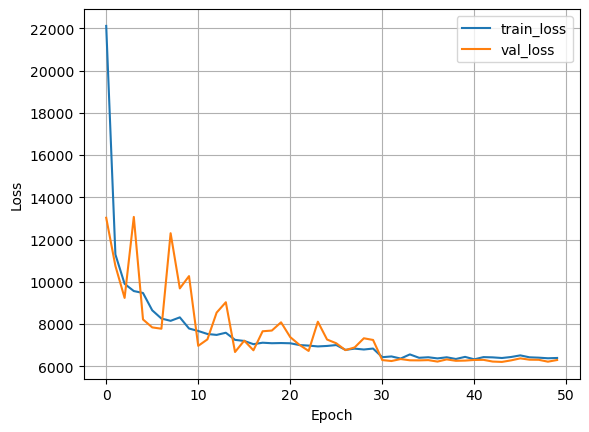

In [3]:
### Plot

metrics = pd.read_csv(f"/data/tim/heronWorkspace/logs/CAEV1/version_0/metrics.csv")

aggreg_metrics = []
agg_col = "epoch"
for i, dfg in metrics.groupby(agg_col):
    agg = dict(dfg.mean())
    agg[agg_col] = i
    aggreg_metrics.append(agg)

df_metrics = pd.DataFrame(aggreg_metrics)
df_metrics[["train_loss", "val_loss"]].plot(
    grid=True, legend=True, xlabel="Epoch", ylabel="Loss"
)

plt.savefig("loss_plt.jpg")

# df_metrics[["train_acc", "val_acc"]].plot(
#     grid=True, legend=True, xlabel="Epoch", ylabel="ACC"
# )

# plt.savefig("suggest_acc.pdf")

plt.show()


## Dataset/Loader testing

In [82]:
# play around with different loader settings
data = HeronImageLoader.HeronDatasetCAE(cameras=["SBU3"])
loader = DataLoader(data, batch_size=2, num_workers=1, shuffle=False) # batch_size=64, num_workers=3
unnorm = HeronImageLoader.UnNormalize()
for i, (imArr, _, _) in enumerate(loader):
    # print(imArr[0])
    for j in range(len(imArr)):
        print("Normalized:")
        print(f'Mean: ' + str(imArr[j].mean(axis=(1, 2))))
        plt.imshow(imArr[j].permute(1, 2, 0))
        plt.show()
        unnormArr = unnorm(imArr)

        print("UnNormalized:")
        plt.imshow(unnormArr[j].permute(1, 2, 0))
        plt.show()
    if i >0 :
        break

File not found: MotionGrayClassification/classifiedMotionGraySBU3.csv
Classifying images of camera: SBU3 into grayscale/rgb and motion/static sensor


  1%|          | 12/1157 [00:53<1:25:12,  4.46s/it]


KeyboardInterrupt: 

## basic models

In [ ]:
# basic model with 150 epochs and big bottleneck

caeLoaded = AEHeronModel.load_from_checkpoint("/data/tim/heronWorkspace/logs/basicCAEBigBottleneck/version_0/checkpoints/epoch=149-step=35400.ckpt")
dataLoader = DataLoader(HeronImageLoader.HeronDataset(set="onlyPos", resize_to=(215, 323)), batch_size=16, shuffle=False, num_workers=4)
trainer = pl.Trainer()
res = trainer.predict(caeLoaded, dataloaders=dataLoader)

In [ ]:
# basic model with 10 epochs and big bottleneck
caeLoaded = AEHeronModel.load_from_checkpoint("/data/tim/heronWorkspace/logs/basicCAE/version_0/checkpoints/epoch=9-step=630.ckpt")
dataLoader = DataLoader(HeronImageLoader.HeronDataset(set="onlyPos", resize_to=(215, 323)), batch_size=16, shuffle=False, num_workers=4)
trainer = pl.Trainer()
res = trainer.predict(caeLoaded, dataloaders=dataLoader)

# MLP

In [ ]:
dataset = HeronImageLoader.HeronDataset(set="testMLP", resize_to=(215, 323))
print(len(dataset))

In [ ]:
# train mlp
caeLoaded = AEHeronModel.load_from_checkpoint("/data/tim/heronWorkspace/logs/basicCAE/version_0/checkpoints/epoch=9-step=630.ckpt")
caeLoaded.freeze()
mlp = MLP(mlpModel=MLPBasic(), cae=caeLoaded, batch_size=16, num_workers_loader=4)
trainer = pl.Trainer(max_epochs=1, accelerator='cuda', log_every_n_steps=1)
trainer.fit(mlp)

In [ ]:
# test mlp
trainer = pl.Trainer(max_epochs=1, accelerator='cuda', log_every_n_steps=1)
caeLoaded = AEHeronModel.load_from_checkpoint("/data/tim/heronWorkspace/logs/basicCAESmallBottleneckLinearLayer/version_0/checkpoints/epoch=23-step=5664.ckpt", model=CAESmallBottleneckWithLinear(), imsize=(216, 324))
caeLoaded.freeze()
mlpLoaded = MLP.load_from_checkpoint("/data/tim/heronWorkspace/logs/basicMLPV1Resized/version_1/checkpoints/epoch=23-step=1872.ckpt", cae=caeLoaded, mlpModel=MLPBasic())
trainer.predict(mlpLoaded)

In [ ]:
trainer = pl.Trainer(max_epochs=1, accelerator='cuda', log_every_n_steps=1)
caeLoaded = AEHeronModel.load_from_checkpoint("/data/tim/heronWorkspace/logs/basicCAESmallBottleneckLinearLayer/version_0/checkpoints/epoch=23-step=5664.ckpt", model=CAESmallBottleneckWithLinear(), imsize=(216, 324))
caeLoaded.freeze()
mlpLoaded = MLPMSEHeatMap.load_from_checkpoint("/data/tim/heronWorkspace/logs/basicMLPHeatMapValidatedSBU4/version_13/checkpoints/epoch=77-step=780.ckpt", cae=caeLoaded, mlpModel=MLPBasicHeatMap(num_features=6))
trainer.predict(mlpLoaded)

# Distance from last reproduction to current

As the distance between two frames is 15 minutes, we can assume that the background stays the same but anomalies such as animals or humans move within 15 minutes.
we can then subtract the two consecutive image distances (current - before) and 0 all the negative values to get only the anomalies of the current picture

next step could be: 
- extract noise from the difference image
- bring image before and after to the same intensity as the current

evtl differenz zum vorderen und zum letzten, dann sind anomalien von anderen bildern weniger gewichtet

In [ ]:
# test distance from last prediction to current

def heatMap(before: torch.Tensor, after: torch.Tensor, stepY, stepX):
    heatMap = []
    for i in range(0, before.shape[-2]-stepY+1, stepY):
        row = []
        for j in range(0, before.shape[-1]-stepX+1, stepX):
            row.append(F.mse_loss(before[:, i:i+stepY, j:j+stepX], after[:, i:i+stepY, j:j+stepX]).item())
        heatMap.append(row)
    return torch.tensor(heatMap).type_as(before)

caeLoaded = AEHeronModel.load_from_checkpoint("/data/tim/heronWorkspace/logs/basicCAE/version_0/checkpoints/epoch=9-step=630.ckpt")
caeLoaded.freeze()
dataLoader = DataLoader(HeronImageLoader.HeronDataset(set="test", resize_to=(215, 323), sorted=True), batch_size=1, shuffle=False, num_workers=4)
print(len(dataLoader.dataset.imagePaths))
unnorm = HeronImageLoader.UnNormalize()

stepY = 5
stepX = 5

lastImd = np.zeros((int(215/stepY), int(323/stepX)))
for i, img in enumerate(list(dataLoader)[200:]):
    # print(img[0].size())
    # plt.imshow(unnorm(img[0][0]).permute(1, 2, 0))
    img = img[0].to(caeLoaded.device)
    pred = caeLoaded(img)
    # img = unnorm(img[0][0]).permute(1, 2, 0).numpy()
    # pred = unnorm(pred[0].cpu()).permute(1, 2, 0).numpy()
    
    img, pred = [unnorm(x) for x in [img[0], pred[0]]]
    imd = heatMap(img, pred, stepY, stepX)

    img, pred = [x.permute(1, 2, 0).cpu().numpy() for x in [img, pred]]
    imd = imd.cpu().numpy()
    # imd = 0.0 + np.sum(img - pred, axis=2)**2
    # imd = np.linalg.norm(im - x, axis=2)

    # imd = imd / (np.max(imd) - np.min(imd))
    # imd = (imd - np.min(imd)) / (np.max(imd) - np.min(imd))

    f, a = plt.subplots(1,5, figsize=(50,10))
    # f.suptitle(fi)

   
    a[0].imshow(img)
    a[1].imshow(pred)
    ma = a[2].imshow(np.abs(imd), cmap="hot", interpolation='none')
    a[3].imshow(np.abs(imd - lastImd), cmap="hot", interpolation='none')

    diff = imd - lastImd
    a[4].imshow(np.where(diff < 0, 0, diff), cmap="hot", interpolation='none')

    plt.show()

    lastImd = imd
    
    if (i > 100):
        break

In [ ]:
# test distance from last prediction to current

def heatMap(before: torch.Tensor, after: torch.Tensor, stepY, stepX):
    heatMap = []
    for i in range(0, before.shape[-2]-stepY+1, stepY):
        row = []
        for j in range(0, before.shape[-1]-stepX+1, stepX):
            row.append(F.mse_loss(before[:, i:i+stepY, j:j+stepX], after[:, i:i+stepY, j:j+stepX]).item())
        heatMap.append(row)
    return torch.tensor(heatMap).type_as(before)

caeLoaded = AEHeronModel.load_from_checkpoint("/data/tim/heronWorkspace/logs/basicCAE/version_0/checkpoints/epoch=9-step=630.ckpt")
caeLoaded.freeze()
dataLoader = DataLoader(HeronImageLoader.HeronDataset(set="test", resize_to=(215, 323), sorted=True), batch_size=1, shuffle=False, num_workers=4)
print(len(dataLoader.dataset.imagePaths))
unnorm = HeronImageLoader.UnNormalize()

stepY = 3
stepX = 3

lastImd = np.zeros((int(215/stepY), int(323/stepX)))
beforeLastImd = np.zeros((int(215/stepY), int(323/stepX)))
lastPred = np.zeros((225, 323, 3))
lastImg = np.zeros((225, 323, 3))

blur = GaussianBlur(kernel_size=3, sigma=0.7)

for i, img in enumerate(list(dataLoader)[100:]):
    # print(img[0].size())
    # plt.imshow(unnorm(img[0][0]).permute(1, 2, 0))
    lbl = img[1].cpu().item()
    img = img[0].to(caeLoaded.device)

    pred = caeLoaded(img)
    # img = unnorm(img[0][0]).permute(1, 2, 0).numpy()
    # pred = unnorm(pred[0].cpu()).permute(1, 2, 0).numpy()
    
    img, pred = [unnorm(x) for x in [img[0], pred[0]]]
    imd = heatMap(img, pred, stepY, stepX)

    img, pred = [x.permute(1, 2, 0).cpu().numpy() for x in [img, pred]]
    imd = imd.cpu().numpy()
    # imd = 0.0 + np.sum(img - pred, axis=2)**2
    # imd = np.linalg.norm(im - x, axis=2)

    # imd = imd / (np.max(imd) - np.min(imd))
    # imd = (imd - np.min(imd)) / (np.max(imd) - np.min(imd))

    f, a = plt.subplots(1,11, figsize=(110,10))
    # f.suptitle(fi)

    beforeDiff = lastImd - beforeLastImd
    nextDiff = lastImd - imd

    # print(imd.shape)
   
    a[0].imshow(lastImg)
    a[0].text(-0.5,0.5, f'True: {lbl}', size=100, ha="center", transform=a[0].transAxes)
    a[0].text(0.5,-0.2, f'current Image', size=20, ha="center", transform=a[0].transAxes)

    a[1].imshow(lastPred)
    a[1].text(0.5,-0.2, f'prediction', size=20, ha="center", transform=a[1].transAxes)

    a[2].imshow(np.abs(lastImd), cmap="hot", interpolation='none')
    a[2].text(0.5,-0.2, f'difference\nimd =|currImg - pred|', size=20, ha="center", transform=a[2].transAxes)

    a[3].imshow(np.abs(beforeDiff), cmap="hot", interpolation='none')
    a[3].text(0.5,-0.2, f'|Imd - ImdPrev|', size=20, ha="center", transform=a[3].transAxes)


    a[4].imshow(np.where(beforeDiff < 0, 0, beforeDiff), cmap="hot", interpolation='none')
    a[4].text(0.5,-0.2, f'|Imd - ImdPrev|\nonly Positives', size=20, ha="center", transform=a[4].transAxes)


    onlyPosDiffBefore = np.where(beforeDiff < 0, 0, beforeDiff)
    onlyPosDiffNext = np.where(nextDiff < 0, 0, nextDiff)
    a[5].imshow(np.divide(np.add(onlyPosDiffBefore, onlyPosDiffNext), 2.0), cmap = "hot", interpolation='none')

    im = Image.fromarray(np.uint8(np.divide(np.add(onlyPosDiffBefore, onlyPosDiffNext), 2.0) * 255))
    a[5].text(0.5,-0.2, f'only Positives:\n(|Imd - ImdPrev| + |Imd - ImdNext|', size=20, ha="center", transform=a[5].transAxes)
    
    a[6].imshow(im.filter(ImageFilter.GaussianBlur(0.01)), cmap = "hot", interpolation='none')
    a[6].text(0.5,-0.2, f'blurPil', size=20, ha="center", transform=a[6].transAxes)

    a[7].imshow(blur.forward(im), cmap = "hot", interpolation='none')
    a[7].text(0.5,-0.2, f'blurTorch', size=20, ha="center", transform=a[7].transAxes)

    a[8].imshow(im.filter(ImageFilter.EDGE_ENHANCE), cmap = "hot", interpolation='none')
    a[8].text(0.5,-0.2, f'edgeEnhance', size=20, ha="center", transform=a[8].transAxes)

    a[9].imshow(im.filter(ImageFilter.SMOOTH), cmap = "hot", interpolation='none')
    a[9].text(0.5,-0.2, f'smooth', size=20, ha="center", transform=a[9].transAxes)

    a[10].imshow(im.filter(ImageFilter.CONTOUR), cmap = "hot", interpolation='none')
    a[10].text(0.5,-0.2, f'contour', size=20, ha="center", transform=a[10].transAxes)


    # a[6].imshow(im.filter(ImageFilter.BLUR), cmap = "hot", interpolation='none')
    # a[7].imshow(im, cmap="hot", interpolation='none')
    # a[9].imshow(im.filter(ImageFilter.CONTOUR), cmap = "hot", interpolation='none')
    
    plt.show()

    beforeLastImd = lastImd
    lastImd = imd
    lastPred = pred
    lastImg = img
    
    if (i > 10):
        break

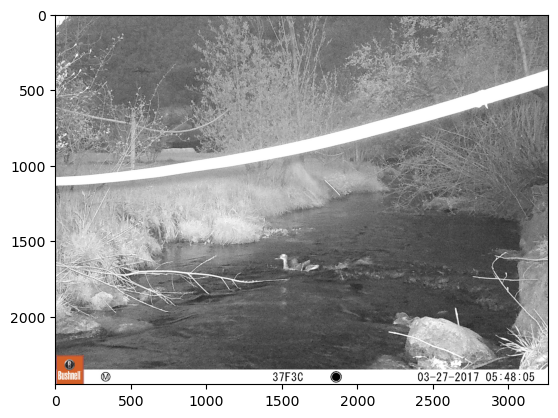

In [8]:
im = Image.open("/data/shared/herons/TinaDubach_data/SBU3/2017_SBU3_03270046.JPG")
plt.imshow(im)
# im.thumbnail((215, 323), Image.Resampling.LANCZOS)
# plt.imshow(im.filter(ImageFilter.GaussianBlur(1)), cmap = "hot", interpolation='none')
plt.show()

### Same thing without heatmap

In [ ]:
# test distance from last prediction to current

def heatMap(before: torch.Tensor, after: torch.Tensor, stepY, stepX):
    heatMap = []
    for i in range(0, before.shape[-2]-stepY+1, stepY):
        row = []
        for j in range(0, before.shape[-1]-stepX+1, stepX):
            row.append(F.mse_loss(before[:, i:i+stepY, j:j+stepX], after[:, i:i+stepY, j:j+stepX]).item())
        heatMap.append(row)
    return torch.tensor(heatMap).type_as(before)

caeLoaded = AEHeronModel.load_from_checkpoint("/data/tim/heronWorkspace/logs/basicCAE/version_0/checkpoints/epoch=9-step=630.ckpt")
caeLoaded.freeze()
dataLoader = DataLoader(HeronImageLoader.HeronDataset(set="test", resize_to=(215, 323), sorted=True), batch_size=1, shuffle=False, num_workers=4)
# print(len(dataLoader.dataset.imagePaths))
unnorm = HeronImageLoader.UnNormalize()

stepY = 5
stepX = 5

lastImd = np.zeros((int(215), int(323)))
beforeLastImd = np.zeros((int(215), int(323)))
lastPred = np.zeros((225, 323, 3))
lastImg = np.zeros((225, 323, 3))

# blur = GaussianBlur(kernel_size=5, sigma=1.0)

for i, img in enumerate(list(dataLoader)[200:]):
    # print(img[0].size())
    # plt.imshow(unnorm(img[0][0]).permute(1, 2, 0))
    img = img[0].to(caeLoaded.device)
    pred = caeLoaded(img)
    # img = unnorm(img[0][0]).permute(1, 2, 0).numpy()
    # pred = unnorm(pred[0].cpu()).permute(1, 2, 0).numpy()
    
    img, pred = [unnorm(x) for x in [img[0], pred[0]]]
    # imd = heatMap(img, pred, stepY, stepX)

    img, pred = [x.permute(1, 2, 0).cpu().numpy() for x in [img, pred]]
    imd = 0.0 + np.sum(img - pred, axis=2)**2
    # imd = imd.cpu().numpy()
    # imd = 0.0 + np.sum(img - pred, axis=2)**2
    # imd = np.linalg.norm(im - x, axis=2)

    # imd = imd / (np.max(imd) - np.min(imd))
    # imd = (imd - np.min(imd)) / (np.max(imd) - np.min(imd))

    f, a = plt.subplots(1,10, figsize=(100,10))
    # f.suptitle(fi)

    beforeDiff = lastImd - beforeLastImd
    nextDiff = lastImd - imd

   
    a[0].imshow(lastImg)
    a[1].imshow(lastPred)
    a[2].imshow(np.abs(lastImd), cmap="hot", interpolation='none')
    a[3].imshow(np.abs(beforeDiff), cmap="hot", interpolation='none')

    a[4].imshow(np.where(beforeDiff < 0, 0, beforeDiff), cmap="hot", interpolation='none')

    onlyPosDiffBefore = np.where(beforeDiff < 0, 0, beforeDiff)
    onlyPosDiffNext = np.where(nextDiff < 0, 0, nextDiff)
    a[5].imshow(np.divide(np.add(onlyPosDiffBefore, onlyPosDiffNext), 2.0), cmap="hot", interpolation='none')

    im = Image.fromarray(np.uint8(np.divide(np.add(onlyPosDiffBefore, onlyPosDiffNext), 2.0)*255))
    a[6].imshow(im.filter(ImageFilter.BLUR), cmap = "hot", interpolation='none')
    a[7].imshow(im.filter(ImageFilter.EDGE_ENHANCE), cmap = "hot", interpolation='none')
    a[8].imshow(im.filter(ImageFilter.SMOOTH), cmap = "hot", interpolation='none')
    a[9].imshow(im.filter(ImageFilter.CONTOUR), cmap = "hot", interpolation='none')

    
    plt.show()

    beforeLastImd = lastImd
    lastImd = imd
    lastPred = pred
    lastImg = img
    
    if (i > 30):
        break

### With trained models from datasets "NEN1", "SBU3"

SNR(signal to noise ratio): np.mean()/np.std()

"batch_size":         16
"bottleneck":         16
"cameras":            ['NEN1', 'SBU3']
"gammaScheduler":     0.1
"ldim":               8
"learning_rate":      0.047851778915716105
"num_workers_loader": 4
"transforms":         None
"weight_decay":       3.057132942161377e-08
Length Dataset: 1112
Start Loop


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


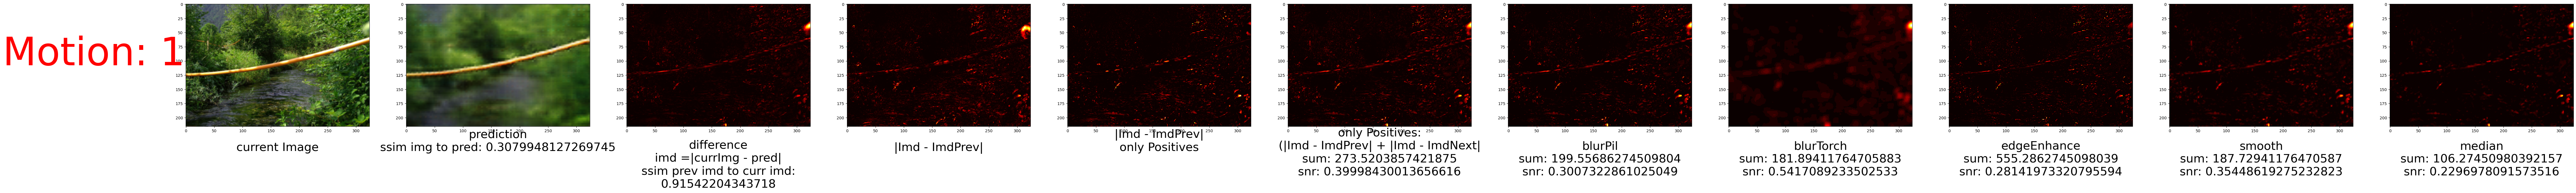

In [26]:

def heatMap(before: torch.Tensor, after: torch.Tensor, stepY, stepX):
    heatMap = []
    for i in range(0, before.shape[-2]-stepY+1, stepY):
        row = []
        for j in range(0, before.shape[-1]-stepX+1, stepX):
            row.append(F.mse_loss(before[:, i:i+stepY, j:j+stepX], after[:, i:i+stepY, j:j+stepX]).item())
        heatMap.append(row)
    return torch.tensor(heatMap).type_as(before)


checkPoint = '/data/tim/heronWorkspace/logs/CAEV1/version_0/checkpoints/epoch=48-step=18963.ckpt'
caeLoaded = CAEHeron.load_from_checkpoint(checkPoint, model = CAEV1)
caeLoaded.freeze()
print(caeLoaded.hparams)

dataLoader = DataLoader(MLPDatasetThreeConsecutive(set="test", resize_to=CAEV1.imsize, cameras=caeLoaded.hparams.cameras), batch_size=1, shuffle=True, num_workers=4)
print(f'Length Dataset: {len(dataLoader.dataset.imagePaths)}')
unnorm = HeronImageLoader.UnNormalize()


stepY = 1
stepX = 1

blur = GaussianBlur(kernel_size=11, sigma=5)
# ssim = StructuralSimilarityIndexMeasure(reduction="none")

print("Start Loop")

for i, (imArr, lblArr, _) in enumerate(dataLoader):
    lbl = lblArr[0].item()
    imgs = [x.to(caeLoaded.device) for x in imArr] #three consecutive images

    preds = [caeLoaded(x) for x in imgs] #imgs are already of shape (1, 3, 215, 323)
    
    # print(preds)

    imgs = [unnorm(x.squeeze(0)) for x in imgs]
    preds = [unnorm(x.squeeze(0)) for x in preds]

    imds = [heatMap(img, pred, stepY, stepX) for img, pred in zip(imgs, preds)]

    imgs = [x.permute(1, 2, 0).cpu().numpy() for x in imgs]
    preds = [x.permute(1, 2, 0).cpu().numpy() for x in preds]
    imds = [x.cpu().numpy() for x in imds]
   
    f, a = plt.subplots(1,11, figsize=(110,10))

    preDiff = imds[1] - imds[0]
    nextDiff = imds[1] - imds[2]


    # preDiff, nextDiff = [np.array(blur.forward(Image.fromarray(np.uint8(x * 255)))) for x in [preDiff, nextDiff]]

    # print(imd.shape)
   
    a[0].imshow(imgs[1])
    a[0].text(-0.5,0.5, f'Motion: {lbl}', size=100, ha="center", color = "red", transform=a[0].transAxes)
    a[0].text(0.5,-0.2, f'current Image', size=30, ha="center", transform=a[0].transAxes)

    a[1].imshow(preds[1])
    a[1].text(0.5,-0.2, f'prediction\nssim img to pred: {ssim(imgs[0], preds[0], channel_axis=2, data_range=1)}', size=30, ha="center", transform=a[1].transAxes)

    a[2].imshow(np.abs(imds[1]), cmap="hot", interpolation='none')
    a[2].text(0.5,-0.5, f'difference\nimd =|currImg - pred|\nssim prev imd to curr imd:\n{ssim(imds[0], imds[1], data_range=1)}', size=30, ha="center", transform=a[2].transAxes)

    a[3].imshow(np.abs(preDiff), cmap="hot", interpolation='none')
    a[3].text(0.5,-0.2, f'|Imd - ImdPrev|', size=30, ha="center", transform=a[3].transAxes)

    onlyPosDiffPred = np.where(preDiff < 0, 0, preDiff)

    a[4].imshow(onlyPosDiffPred, cmap="hot", interpolation='none')
    a[4].text(0.5,-0.2, f'|Imd - ImdPrev|\nonly Positives', size=30, ha="center", transform=a[4].transAxes)


    onlyPosDiffNext = np.where(nextDiff < 0, 0, nextDiff)

    posDiffPredAndNext = np.divide(np.add(onlyPosDiffPred, onlyPosDiffNext), 2.0)
    snr = np.mean(posDiffPredAndNext)/np.std(posDiffPredAndNext)
    a[5].imshow(posDiffPredAndNext, cmap = "hot", interpolation='none')
    a[5].text(0.5,-0.4, f'only Positives:\n(|Imd - ImdPrev| + |Imd - ImdNext|\nsum: {np.sum(posDiffPredAndNext)}\nsnr: {snr}', size=30, ha="center", transform=a[5].transAxes)

    posDiffPredAndNextPil = Image.fromarray(np.uint8(posDiffPredAndNext * 255))
    
    filtered = posDiffPredAndNextPil.filter(ImageFilter.GaussianBlur(0.01))
    a[6].imshow(filtered, cmap = "hot", interpolation='none')
    a[6].text(0.5,-0.4, f'blurPil\nsum: {np.sum(filtered)/255}\nsnr: {np.mean(filtered)/np.std(filtered)}', size=30, ha="center", transform=a[6].transAxes)

    filtered = blur.forward(posDiffPredAndNextPil)
    a[7].imshow(filtered, cmap = "hot", interpolation='none')
    a[7].text(0.5,-0.4, f'blurTorch\nsum: {np.sum(filtered)/255}\nsnr: {np.mean(filtered)/np.std(filtered)}', size=30, ha="center", transform=a[7].transAxes)

    filtered = posDiffPredAndNextPil.filter(ImageFilter.EDGE_ENHANCE)
    a[8].imshow(filtered, cmap = "hot", interpolation='none')
    a[8].text(0.5,-0.4, f'edgeEnhance\nsum: {np.sum(filtered)/255}\nsnr: {np.mean(filtered)/np.std(filtered)}', size=30, ha="center", transform=a[8].transAxes)

    filtered = posDiffPredAndNextPil.filter(ImageFilter.SMOOTH)
    a[9].imshow(filtered, cmap = "hot", interpolation='none')
    a[9].text(0.5,-0.4, f'smooth\nsum: {np.sum(filtered)/255}\nsnr: {np.mean(filtered)/np.std(filtered)}', size=30, ha="center", transform=a[9].transAxes)

    filtered = posDiffPredAndNextPil.filter(ImageFilter.MedianFilter)
    a[10].imshow(filtered, cmap = "hot", interpolation='none')
    a[10].text(0.5,-0.4, f'median\nsum: {np.sum(filtered)/255}\nsnr: {np.mean(filtered)/np.std(filtered)}', size=30, ha="center", transform=a[10].transAxes)

    
    plt.show()
    
    if (i > 30):
        break
    


# Model with small bottleneck and linear layer

In [4]:
# Model
cae = AEHeronModel(batch_size=16, num_workers_loader=4, model=CAESmallBottleneckWithLinear(), imsize=(216, 324))
summary(cae, (3, 216, 324), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 8, 72, 108]             600
       BatchNorm2d-2           [-1, 8, 72, 108]              16
         LeakyReLU-3           [-1, 8, 72, 108]               0
            Conv2d-4           [-1, 16, 24, 36]           3,200
       BatchNorm2d-5           [-1, 16, 24, 36]              32
         LeakyReLU-6           [-1, 16, 24, 36]               0
            Conv2d-7            [-1, 32, 8, 12]          12,800
       BatchNorm2d-8            [-1, 32, 8, 12]              64
         LeakyReLU-9            [-1, 32, 8, 12]               0
          Flatten-10                 [-1, 3072]               0
           Linear-11                  [-1, 256]         786,688
           Linear-12                 [-1, 3072]         789,504
        Unflatten-13            [-1, 32, 8, 12]               0
  ConvTranspose2d-14           [-1, 16,

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/data/tim/miniforge3/envs/heronsTim/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:67: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
LOCAL_RANK: 0 - CUDA

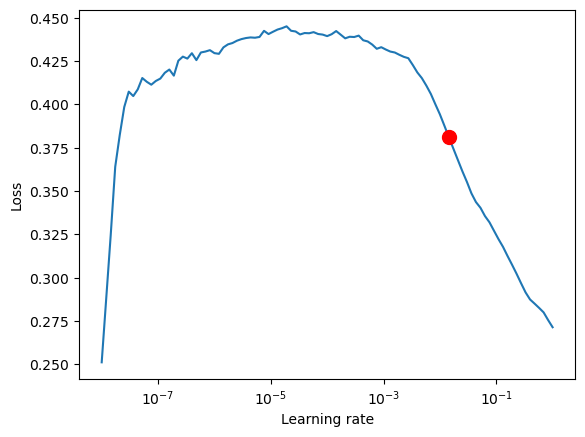

0.01445439770745928


In [5]:
# Find learning rate
trainer = pl.Trainer( accelerator='cuda', max_epochs=30) # devices is the index of the gpu, callbacks=[FineTuneLearningRateFinder(milestones=(5, 10))],
tuner = Tuner(trainer)
lr_finder = tuner.lr_find(cae)
lr_finder.plot(show=True, suggest=True)
print(lr_finder.suggestion())

In [7]:
# Train
cae = AEHeronModel(batch_size=16, learning_rate=lr_finder.suggestion(), num_workers_loader=4, model=CAESmallBottleneckWithLinear(), imsize=(216, 324))
trainer = pl.Trainer( accelerator='cuda', max_epochs=1, logger=CSVLogger(save_dir="logs/", name="linearSmallBottleNeck"), log_every_n_steps=1) # devices is the index of the gpu, callbacks=[FineTuneLearningRateFinder(milestones=(5, 10))],
trainer.fit(cae)

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: logs/linearSmallBottleNeck
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type                         | Params
-------------------------------------------------------
0 | model | CAESmallBottleneckWithLinear | 1.6 M 
-------------------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.438     Total estimated model params size (MB)


Epoch 0:  10%|▉         | 46/472 [00:44<06:56,  1.02it/s, v_num=0, train_loss=0.081] 

/data/tim/miniforge3/envs/heronsTim/lib/python3.8/site-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


Load trained version

In [4]:
caeLoaded = AEHeronModel.load_from_checkpoint("/data/tim/heronWorkspace/logs/basicCAESmallBottleneckLinearLayer/version_0/checkpoints/epoch=23-step=5664.ckpt", model=CAESmallBottleneckWithLinear(), imsize=(216, 324))

In [ ]:
trainer = pl.Trainer()
trainer.predict(caeLoaded)

# Camera evaluation
Evaluate which is the best camera to train

In [29]:
cameraDataDF = pd.read_csv("/data/shared/herons/TinaDubach_data/CameraData_2017_july.csv", encoding='unicode_escape', on_bad_lines="warn", sep=";")
cameraDataDF = cameraDataDF[cameraDataDF["code"].isna()]
cameraDataDF

,camera,mode,date,time,code,code1,temperatur,infrared,species,stream,stream section,grey heron,fotocode,forname,year
434,KBU4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,KBU,4,0,2017_KBU4_NA,_,2017
1509,SBU1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"06120841-06140999 camera turned 90°, only bank...",SBU,1,0,2017_SBU1_NA,_,2017
1510,SBU1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,06140001-6140073; 0615007406150128; only bank 90°,SBU,1,0,2017_SBU1_NA,_,2017
1511,SBU1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,06150129-06230999 same,SBU,1,0,2017_SBU1_NA,_,2017
1512,SBU1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,06230001-06270348 total 348,SBU,1,0,2017_SBU1_NA,_,2017
4055,SGN1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Red-crested pochard (Netta rufina),SGN,1,0,2017_SGN1_NA,_,2017
4170,SGN2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SGN,2,0,2017_SGN2_NA,_,2017


In [32]:
description = {
    "SBU4": "house in the background with a lot of anomalies, lots of herons in the test set",
    "SBU1": "house and street beside the river with lots of anomalies, cam wrong position for some photos",
    "NEN1": "good camera, not many anomalies in the background, change of camera position in the end of the summer",
    "SGN1": "camera in reed plants for ~1/2 of the samples, could possibly be used for the first 1/2 part",
    "KBU1" : "sreet in the background, many cars",
    "SGN3" : "street with many people in the background",
    "SBU3" : "good camera, cable in front of it, not much going on in the background",
    "SGN4" : "street with many people in the background",
    "NEN3" : "street in the background with cars, could be cut out, otherwise calm background",
    "SBU2" : "path in the background, medium many people",

}

# evaluation if different camera trap is better (concretely GBU1)
cameraDataDF = pd.read_csv("/data/shared/herons/TinaDubach_data/CameraData_2017_july.csv", encoding='unicode_escape', on_bad_lines="warn", sep=";")
#cameraDataDF.describe()
folders = cameraDataDF.groupby(["camera"]).size().sort_values(ascending=False)
print(folders)
foldersDF = cameraDataDF[(cameraDataDF["code"].notna())].groupby(["camera"]).agg(nrAnomalies=("grey heron", "count"), nrHerons = ("grey heron", "sum")).sort_values(by=["nrAnomalies"], ascending=False)
foldersDF["description"] = [description[x] if x in description.keys() else None for x in foldersDF.index]
foldersDF.to_csv("camEval.csv")

camera
SBU4    1932
SBU1     313
NEN1     261
SGN1     239
KBU1     233
SGN3     231
SBU3     214
SGN4     213
NEN3     177
SBU2     156
NEN2     131
SGN2     115
KBU2     101
PSU1      70
NEN4      64
PSU3      42
GBU4      39
GBU1      29
PSU2      20
KBU3      18
KBU4      15
dtype: int64


In [74]:
dfUntilSBU2 = pd.read_csv("/data/tim/heronWorkspace/ImageData/imagePropsSBU2.csv") #contains top 10 cameras
unwanted = dfUntilSBU2.columns[dfUntilSBU2.columns.str.startswith('Unnamed')]
dfUntilSBU2.drop(unwanted, axis=1, inplace=True)
dfUntilSBU2 = dfUntilSBU2[dfUntilSBU2["grayscale"] == "False"]
dfUntilSBU2["cam"] = dfUntilSBU2["ImagePath"].str.split("_").str[1]
dfTinaDubach = pd.read_csv("/data/shared/herons/TinaDubach_data/CameraData_2017_july.csv", encoding='unicode_escape', on_bad_lines="warn", sep=";")
dfAll = pd.merge(dfTinaDubach, dfUntilSBU2, left_on="fotocode", how="right", right_on="ImagePath")
dfAll = dfAll.drop_duplicates(subset = ["ImagePath"], keep="first") # drop duplicates
dfAll[["cam", "motion", "ImagePath", "species"]].groupby(["cam", "motion"]).agg(nrFrames = ("ImagePath", "count"), nrAnomalies = ("species", lambda x: x.notna().sum()))

nrFrames  nrAnomalies
cam  motion                       
KBU1 False       9184           53
     True        3290          177
NEN1 False       9125          206
     True         899           47
NEN3 False       9270          136
     True        2966           27
SBU1 False       8764           40
     True        1354            6
SBU2 False       8999           37
     True        2605           26
SBU3 False       9044          113
     True        1908           71
SBU4 False       9095          711
     True        3804          836
SGN1 False       8528          170
     True        2797           51
SGN3 False       9387           86
     True        1947          137
SGN4 False       8655           66
     True        3675          121

In [16]:
cameraDataDF[(cameraDataDF["camera"] == "SBU1") & (cameraDataDF["grey heron"] == 0) & (cameraDataDF["code"].notna())].head(20)

,camera,mode,date,time,code,code1,temperatur,infrared,species,stream,stream section,grey heron,fotocode,forname,year
1233,SBU1,m,2017-01-30,17:01:30,1300388.0,1300388.0,4.0,n,Mallard (Anas platyrhynchos),SBU,1,0,2017_SBU1_01300388,_,2017
1475,SBU1,t,NaN,NaN,5250019.0,5250019.0,NaN,n,Common Merganser (Mergus merganser),SBU,1,0,2017_SBU1_05250019,_,2017
1476,SBU1,t,NaN,NaN,6010712.0,6010712.0,NaN,NaN,Yellow-legged Gull (Larus michahellis),SBU,1,0,2017_SBU1_06010712,_,2017
1484,SBU1,t,NaN,NaN,6060269.0,6060269.0,NaN,NaN,Common Merganser (Mergus merganser),SBU,1,0,2017_SBU1_06060269,_,2017
1497,SBU1,NaN,NaN,NaN,6290617.0,6290617.0,NaN,NaN,Common Merganser (Mergus merganser),SBU,1,0,2017_SBU1_06290617,_,2017
1504,SBU1,NaN,NaN,NaN,7060317.0,7060317.0,NaN,NaN,Eurasian Sparrowhawk (Accipiter nisus),SBU,1,0,2017_SBU1_07060317,_,2017


#### Try out for MLP dataset

In [36]:
df = pd.read_csv('/data/tim/heronWorkspace/MotionGrayClassification/classifiedMotionGraySBU3.csv')
df = df[(df["grayscale"] == False) & (df["badImage"] == False)].sort_values(by=['ImagePath'])
df.head(10)

,camera,ImagePath,badImage,motion,grayscale
5565,SBU3,2017_SBU3_01270001,False,False,False
7830,SBU3,2017_SBU3_01270002,False,False,False
15958,SBU3,2017_SBU3_01270003,False,False,False
5545,SBU3,2017_SBU3_01270004,False,False,False
9046,SBU3,2017_SBU3_01270005,False,False,False
3183,SBU3,2017_SBU3_01270006,False,False,False
15370,SBU3,2017_SBU3_01270007,False,False,False
17660,SBU3,2017_SBU3_01270008,False,False,False
8257,SBU3,2017_SBU3_01280067,False,False,False
4461,SBU3,2017_SBU3_01280068,False,False,False


Feature: ((path before, path curr, path next), curr is motion)

In [37]:
sortedPaths = df["ImagePath"].tolist()
motions = df["motion"].astype(int).tolist()
features = []
for i, row in enumerate(sortedPaths):
    _, _, nrCurr = row.split("_")
    if i > 0 and i < len(sortedPaths)-1:
        _, _, nrPrev = sortedPaths[i-1].split("_")
        _, _, nrNext = sortedPaths[i+1].split("_")
        if int(nrPrev) + 1 == int(nrCurr) and int(nrNext)-1 == int(nrCurr):
            features.append([(sortedPaths[i-1], row, sortedPaths[i+1]), motions[i]])
#     if i > 10:
#         break
# features

In [38]:
featuresNormal = [feature for feature in features if feature[1] == 0]
featuresMotion = [feature for feature in features if feature[1] == 1]
minLen = min(len(featuresNormal), len(featuresMotion))

random.seed(1)
featuresNormal = random.sample(featuresNormal, minLen)
featuresMotion = random.sample(featuresMotion, minLen)

features = featuresNormal + featuresMotion

In [39]:
print(len(df))
print(len(features))

10952
3786


## evaluation of manual dataset validation

In [6]:
df = pd.read_csv("datasetValidation.csv")
unwanted = df.columns[df.columns.str.startswith('Unnamed')]
df.drop(unwanted, axis=1, inplace=True)
print(f'nrAnomalies: {len(df[df["ValidationValue"] > 0])}')
print(f'nrNonAnomalies: {len(df[df["ValidationValue"] <= 0])}')

nrAnomalies: 382
nrNonAnomalies: 1218


382

# Model with NEN1

#### Dataset evaluation

In [10]:
cameraDataDF = pd.read_csv("/data/shared/herons/TinaDubach_data/CameraData_2017_july.csv", encoding='unicode_escape', on_bad_lines="warn", sep=";")
cameraDataNEN1 = cameraDataDF[(cameraDataDF["stream"] == "NEN") & (cameraDataDF["stream section"] == 1)]
cameraDataNEN1.head(3)

,camera,mode,date,time,code,code1,temperatur,infrared,species,stream,stream section,grey heron,fotocode,forname,year
435,NEN1,t,2017-01-28,17:29:29,1280217.0,1280217.0,4.0,n,Grey Heron (Ardea cinerea),NEN,1,1,2017_NEN1_01280217,_,2017
436,NEN1,t,2017-01-30,11:44:26,1300388.0,1300388.0,5.0,n,Grey Heron (Ardea cinerea),NEN,1,1,2017_NEN1_01300388,_,2017
437,NEN1,t,2017-01-30,11:59:26,1300389.0,1300389.0,6.0,n,Grey Heron (Ardea cinerea),NEN,1,1,2017_NEN1_01300389,_,2017


check for data hints in the dataset

In [20]:
cameraDataNEN1[cameraDataNEN1["code"].isna()]

,camera,mode,date,time,code,code1,temperatur,infrared,species,stream,stream section,grey heron,fotocode,forname,year


In [21]:
motionImageDataNEN1 = pd.read_csv("/data/tim/heronWorkspace/ImageData/imagePropsNEN1.csv").drop(columns=["Unnamed: 0", "Unnamed: 0.1", "Unnamed: 0.2"])
dfNEN1 = pd.merge(cameraDataNEN1, motionImageDataNEN1, left_on="fotocode", how="right", right_on="ImagePath")
dfNEN1.head(3)
# only rgb images
dfNEN1 = dfNEN1[dfNEN1["grayscale"] == "False"]

,camera,mode,date,time,code,code1,temperatur,infrared,species,stream,stream section,grey heron,fotocode,forname,year,cam,ImagePath,badImage,motion,grayscale
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.657309e-310,0.0,0.0,0.0,2.37e-322
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.500000e+01,2017_SBU4_03040730,False,False,False
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.500000e+01,2017_SBU4_02060982,False,False,False


In [27]:
nrAnomalyAndMotion = len(dfNEN1[(dfNEN1["species"].notna()) & (dfNEN1["motion"] == "True")])
nrAnomalyWithoutMotion = len(dfNEN1[(dfNEN1["species"].notna()) & (dfNEN1["motion"] == "False")])
trainingImages = len(dfNEN1[dfNEN1["motion"] == "False"])
print("Consider training with rgb frames that aren't labeled as captured with motion sensor")
print(f'Nr of images for training: {trainingImages} samples of which {nrAnomalyWithoutMotion} frames contain anomalies\n')
print(f'{nrAnomalyAndMotion} samples would only be in the set for the mlp')


Consider training with rgb frames that aren't labeled as captured with motion sensor
Nr of images for training: 26985 samples of which 207 frames contain anomalies

49 samples would only be in the set for the mlp
